In [1]:
import datetime; datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

'2022-06-30 13:47:16'

# Vary the learner size while keeping the target fixed

Changed the setting from the previous experiments.

The output weights are U(-1,1) while the stepsize is greatly increased.

The step-size is not swept over

Replacement rate is now 20%

Target size is now 100

Replacemnent is every 20k steps here

I fix the other preiods in order to account for the 20k replacement rate. Also training for longer

# Varying the percentage of the total replacements that the decorrelator is allowed to use

# Fixing the maximization bias

In [1]:
import mariadb
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import itertools
import matplotlib.ticker as ticker

%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns
sns.set(
rc={
 'axes.axisbelow': False,
 'axes.edgecolor': 'black',
 'axes.facecolor': 'None',
 'axes.grid': False,
 "grid.color": "lightgrey",
 'axes.labelcolor': 'black',
 'axes.spines.right': False,
 'axes.spines.top': False,
 'figure.facecolor': 'white',
 'lines.solid_capstyle': 'round',
 'patch.edgecolor': 'w',
 'patch.force_edgecolor': True,
 'text.color': 'black',
 'xtick.bottom': False,
 'xtick.color': 'black',
 'xtick.direction': 'out',
 'xtick.top': False,
 'ytick.color': 'black',
 'ytick.direction': 'out',
 'ytick.left': False,
 'ytick.right': False,
    })
plt.rcParams["figure.figsize"] = (30,7)
sns.set_context("notebook", rc={"font.size":20,
                                "axes.titlesize":20,
                                "axes.labelsize":15})
# paper config below (uncomment)

plt.rcParams.update({
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'font.size': 15,
    'figure.autolayout': True,
    'figure.figsize': (7.2,4.45),
    'axes.titlesize' : 16,
    'axes.labelsize' : 17,
    'lines.linewidth' : 2,
    'lines.markersize' : 6,
    'legend.fontsize': '13',
    'mathtext.fontset': 'stix',
    'font.family': 'STIXGeneral',
    
    })

# some irrelavant config
#CB91_Blue = '#2CBDFE'
#CB91_Green = '#47DBCD'
#CB91_Pink = '#F3A0F2'
#CB91_Purple = '#9D2EC5'
#CB91_Violet = '#661D98'
#CB91_Amber = '#F5B14C'
#color_list = [CB91_Purple, CB91_Blue, CB91_Pink, CB91_Green,
#              CB91_Amber, CB91_Violet]
#plt.rcParams['axes.prop_cycle'] = plt.cycler(color=color_list)
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=sns.color_palette("bright"))
sns.color_palette("bright")

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]

In [3]:
from cycler import cycler

fsize = 15
tsize = 18
tdir = 'in'
major = 5.0
minor = 3.0
lwidth = 0.7
lhandle = 2.0
plt.style.use('default')
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = fsize
plt.rcParams['legend.fontsize'] = tsize
plt.rcParams['xtick.direction'] = tdir
plt.rcParams['ytick.direction'] = tdir
plt.rcParams['xtick.major.size'] = major
plt.rcParams['xtick.minor.size'] = minor
plt.rcParams['ytick.major.size'] = 5.0
plt.rcParams['ytick.minor.size'] = 3.0
plt.rcParams['axes.linewidth'] = lwidth
plt.rcParams['legend.handlelength'] = lhandle

line_cycler   = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["-", "--", "-.", ":", "-", "--", "-."]))
marker_cycler = (cycler(color=["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00", "#CC79A7", "#F0E442"]) +
                 cycler(linestyle=["none", "none", "none", "none", "none", "none", "none"]) +
                 cycler(marker=["4", "2", "3", "1", "+", "x", "."]))
standard_cycler = cycler("color", ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"])
plt.rc("axes", prop_cycle=standard_cycler)


In [4]:
class DbAccessor:
    def __init__(self, db_name, cfg_primary_key="run_id", timestep_col_name="episode", local=False, gc=False, gc2=False):
        #params:
        #    cfg_primary_key: the key that is used to index the runs
        #    timestep_col_name: the column which contains the timestep values to be used in plots (or any other column to index with/use as x-axis)
        self.cfg_primary_key = cfg_primary_key
        self.timestep_col_name = timestep_col_name
        try:
            if local:
                    self.conn = mariadb.connect(user="haseebs",
                                                password="",
                                                host="localhost",
                                                port=3306,
                                                database=db_name)
            elif gc:
                self.conn = mariadb.connect(user='rlai',
                                            password=os.environ['gcpswd'],
                                            host='35.203.104.151',
                                            database=db_name)
            elif gc2:
                self.conn = mariadb.connect(user='narval',
                                            password=os.environ['narvalpswd'],
                                            host='34.152.53.247',
                                            database=db_name)
            else:
                # requires ssh tunnel to ccdb
                self.conn = mariadb.connect(user='hshah1',
                                            password=os.environ['cedarsqlpswd'],
                                            host='127.0.0.1',
                                            port=3307,
                                            database=db_name)
        except mariadb.Error as e:
            print(f"Error connecting to MariaDB Platform: {e}")
            sys.exit(1)

    def get_table_list(self):
        return pd.read_sql('show tables', self.conn)
    
    def get_table(self, table_name, cfg_filter=None, column_names="*", index=True):
        #params:
        #    cfg_filter: optional value of <cfg_primary_key> to filter the results with
        #    column_names: can be multiple
        #    index: whether the current table is indexed by <timestep_col_name>
        #returns:
        #    <timestep_col_name>'s values + <column_names>'s values
        
        #TODO careful with column names in future...
        if index:
            if column_names != "*":
                column_names += f',{self.timestep_col_name}'

            if cfg_filter:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name} WHERE {self.cfg_primary_key}={cfg_filter}', self.conn).set_index(self.timestep_col_name)
            else:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name}', self.conn).set_index(self.timestep_col_name)            
        else:
            if cfg_filter:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name} WHERE {self.cfg_primary_key}={cfg_filter}', self.conn)
            else:
                return pd.read_sql(f'SELECT {column_names} FROM {table_name}', self.conn)


In [5]:
db1 = DbAccessor('hshah1_0371_rndm_scalability', cfg_primary_key="run", timestep_col_name="step", local=False, gc=True)
pd.read_sql(f'select * from runs', db1.conn)

,name,age_restriction,decorrelate_perc,l1_lambda,l2_lambda,min_estimation_period,n2_decorrelate,n_distractors,n_inputs,n_learner_features,...,random_decorrelate,random_replacement,random_thresh_decorrelate,replace_every,replace_perc,seed,step_size,steps,sum_features,run
0,0371_rndm_scalability,0,0.1,0.0,0.0,5000,0,0,5,25,...,1,0,0,20000,0.2,0,0.01,5000001,0,0
1,0371_rndm_scalability,0,0.1,0.0,0.0,5000,0,0,5,25,...,1,0,0,20000,0.2,0,0.01,5000001,0,1
2,0371_rndm_scalability,0,0.1,0.0,0.0,5000,0,0,5,25,...,1,0,0,20000,0.2,0,0.01,5000001,0,2
3,0371_rndm_scalability,0,0.1,0.0,0.0,5000,0,0,5,25,...,1,0,0,20000,0.2,0,0.01,5000001,0,3
4,0371_rndm_scalability,0,0.1,0.0,0.0,5000,0,0,5,25,...,1,0,0,20000,0.2,0,0.01,5000001,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,0371_rndm_scalability,0,0.1,0.0,0.0,5000,0,0,5,25,...,1,0,0,20000,0.2,29,0.01,5000001,0,265
266,0371_rndm_scalability,0,0.1,0.0,0.0,5000,0,0,5,25,...,1,0,0,20000,0.2,29,0.01,5000001,0,266
267,0371_rndm_scalability,0,0.1,0.0,0.0,5000,0,0,5,25,...,1,0,0,20000,0.2,29,0.01,5000001,0,267
268,0371_rndm_scalability,0,0.1,0.0,0.0,5000,0,0,5,25,...,1,0,0,20000,0.2,29,0.01,5000001,0,268


In [6]:
db2 = DbAccessor('hshah1_0337_fix_maturity', cfg_primary_key="run", timestep_col_name="step", local=False, gc=True)
pd.read_sql(f'select * from runs', db2.conn)

,name,age_restriction,min_estimation_period,n2_decorrelate,n_distractors,n_inputs,n_learner_features,n_target_features,random_decorrelate,random_replacement,random_thresh_decorrelate,replace_every,replace_perc,seed,step_size,steps,sum_features,run
0,0337_fix_maturity,0,5000,0,0,5,5,100,0,0,0,20000,0.2,0,0.01,20000001,0,0
1,0337_fix_maturity,0,5000,0,0,5,10,100,0,0,0,20000,0.2,0,0.01,20000001,0,1
2,0337_fix_maturity,0,5000,0,0,5,25,100,0,0,0,20000,0.2,0,0.01,20000001,0,2
3,0337_fix_maturity,0,5000,0,0,5,50,100,0,0,0,20000,0.2,0,0.01,20000001,0,3
4,0337_fix_maturity,0,5000,0,0,5,100,100,0,0,0,20000,0.2,0,0.01,20000001,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0337_fix_maturity,0,5000,0,0,5,5,100,0,0,0,20000,0.2,29,0.01,20000001,0,145
146,0337_fix_maturity,0,5000,0,0,5,10,100,0,0,0,20000,0.2,29,0.01,20000001,0,146
147,0337_fix_maturity,0,5000,0,0,5,25,100,0,0,0,20000,0.2,29,0.01,20000001,0,147
148,0337_fix_maturity,0,5000,0,0,5,50,100,0,0,0,20000,0.2,29,0.01,20000001,0,148


In [7]:
db3 = DbAccessor('hshah1_0370_no_max_bias', cfg_primary_key="run", timestep_col_name="step", local=False, gc=True)
pd.read_sql(f'select * from runs', db3.conn)

,name,age_restriction,decorrelate_perc,min_estimation_period,n2_decorrelate,n_distractors,n_inputs,n_learner_features,n_target_features,perc_of_total_pairs_to_estimate,random_decorrelate,random_replacement,random_thresh_decorrelate,replace_every,replace_perc,seed,step_size,steps,sum_features,run
0,0370_no_max_bias,0,0.1,5000,0,0,5,25,100,0.0,1,0,0,20000,0.2,0,0.01,5000001,0,0
1,0370_no_max_bias,0,0.1,5000,1,0,5,25,100,0.0,1,0,0,20000,0.2,0,0.01,5000001,0,1
2,0370_no_max_bias,0,0.1,5000,0,0,5,25,100,0.0,1,0,0,20000,0.2,1,0.01,5000001,0,2
3,0370_no_max_bias,0,0.1,5000,1,0,5,25,100,0.0,1,0,0,20000,0.2,1,0.01,5000001,0,3
4,0370_no_max_bias,0,0.1,5000,0,0,5,25,100,0.0,1,0,0,20000,0.2,2,0.01,5000001,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0370_no_max_bias,0,0.1,5000,1,0,5,50,100,0.0,1,0,0,20000,0.2,23,0.01,5000001,0,215
176,0370_no_max_bias,0,0.1,5000,0,0,5,10,100,0.0,1,0,0,20000,0.2,24,0.01,5000001,0,216
177,0370_no_max_bias,0,0.1,5000,1,0,5,10,100,0.0,1,0,0,20000,0.2,24,0.01,5000001,0,217
178,0370_no_max_bias,0,0.1,5000,0,0,5,50,100,0.0,1,0,0,20000,0.2,24,0.01,5000001,0,218


In [12]:
total_runs

array([3000.])

In [9]:
from scipy.ndimage.filters import uniform_filter1d
def moving_avg(x, n):
    return uniform_filter1d(x, size=n)
    #cumsum = np.cumsum(np.insert(x, 0, 0)) 
    #return (cumsum[n:] - cumsum[:-n]) / float(n)

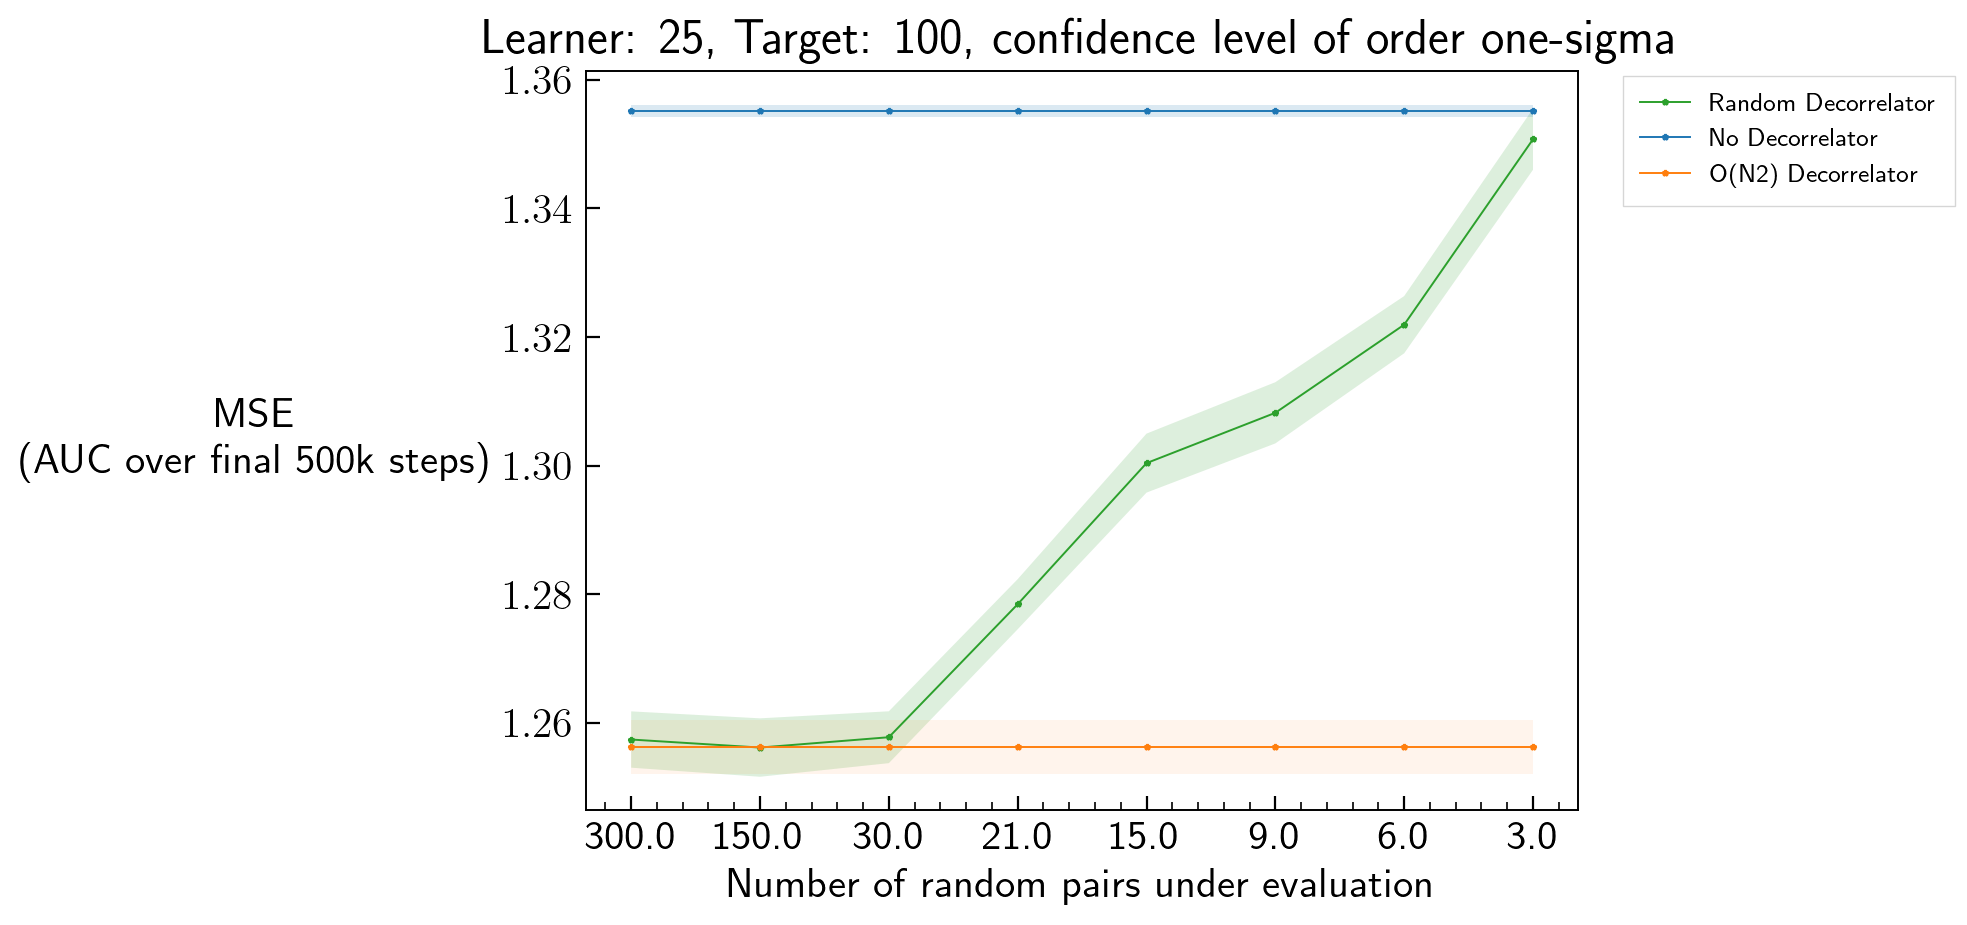

In [11]:

plt_name = f'Learner: 25, Target: 100, confidence level of order one-sigma'
fig, axs = plt.subplots(dpi=200)
plt.title(plt_name)
#plt.title(plt_name)
plt.xlabel('Number of random pairs under evaluation')
plt.ylabel('MSE \n(AUC over final 500k steps)', rotation="horizontal", ha="right", ma="center", va="center")
axs.xaxis.set_tick_params(which='major', bottom=True)
axs.xaxis.set_tick_params(which='minor', bottom=True)
axs.minorticks_on()

colors = plt.cycler(color=sns.color_palette("Set1", n_colors=10)).by_key()['color']
#colors = plt.cycler(color=sns.color_palette("tab10", n_colors=4)).by_key()['color']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

color_idx = 2

values = pd.read_sql(f'select count(*), perc_of_total_pairs_to_estimate, avg(error), std(error)/sqrt(count(*)) from error_table join runs where runs.run = error_table.run and step>=4500001 and perc_of_total_pairs_to_estimate != 0.004 group by perc_of_total_pairs_to_estimate', db1.conn)#.values[:,-1]
total_runs = values.values[:,0]
x_axis = (25*24*0.5*values.values[:,1].astype(float)).astype('str')
#x_axis[3] = '7.0'
x_axis[3] = '21.0'
acc_mean = values.values[:,2]
err = values.values[:,3]
plt.plot(x_axis, acc_mean, label=f"Random Decorrelator", color=colors[color_idx], linestyle='-', linewidth=0.7, marker='*', markersize=2)
plt.fill_between(x_axis, acc_mean-err, acc_mean+err, alpha=0.16, color=colors[color_idx], edgecolor=None)

color_idx = 0 

values = pd.read_sql(f'select count(*), avg(error), std(error)/sqrt(count(*)) from error_table join runs where runs.run = error_table.run and step>=4500001 and n_learner_features=25', db2.conn)#.values[:,-1]
total_runs = values.values[:,0]
acc_mean = np.repeat(values.values[:,1], x_axis.size)
err = np.repeat(values.values[:,2], x_axis.size)
plt.plot(x_axis, acc_mean, label=f"No Decorrelator", color=colors[color_idx], linestyle='-', linewidth=0.7, marker='*', markersize=2)
plt.fill_between(x_axis, acc_mean-err, acc_mean+err, alpha=0.16, color=colors[color_idx], edgecolor=None)

color_idx =1

values = pd.read_sql(f'select count(*), avg(error), std(error)/sqrt(count(*)) from error_table join runs where runs.run = error_table.run and step>=4500001 and n_learner_features=25 and n2_decorrelate=1', db3.conn)#.values[:,-1]
total_runs = values.values[:,0]
acc_mean = np.repeat(values.values[:,1], x_axis.size)
err = np.repeat(values.values[:,2], x_axis.size)
plt.plot(x_axis, acc_mean, label=f"O(N2) Decorrelator", color=colors[color_idx], linestyle='-', linewidth=0.7, marker='*', markersize=2)
plt.fill_between(x_axis, acc_mean-err, acc_mean+err, alpha=0.08, color=colors[color_idx], edgecolor=None)


legend = plt.legend(prop={'size': 9}, bbox_to_anchor=(1.04,1), loc="upper left")
#plt.axhline(y=0.00, color='black', linestyle=':', linewidth=2, alpha=0.3)

frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.5)
frame.set_boxstyle('Square')
plt.yscale('linear')
plt.savefig('figures/plt_scale_err.svg', bbox_inches='tight', transparent=True)
plt.show()

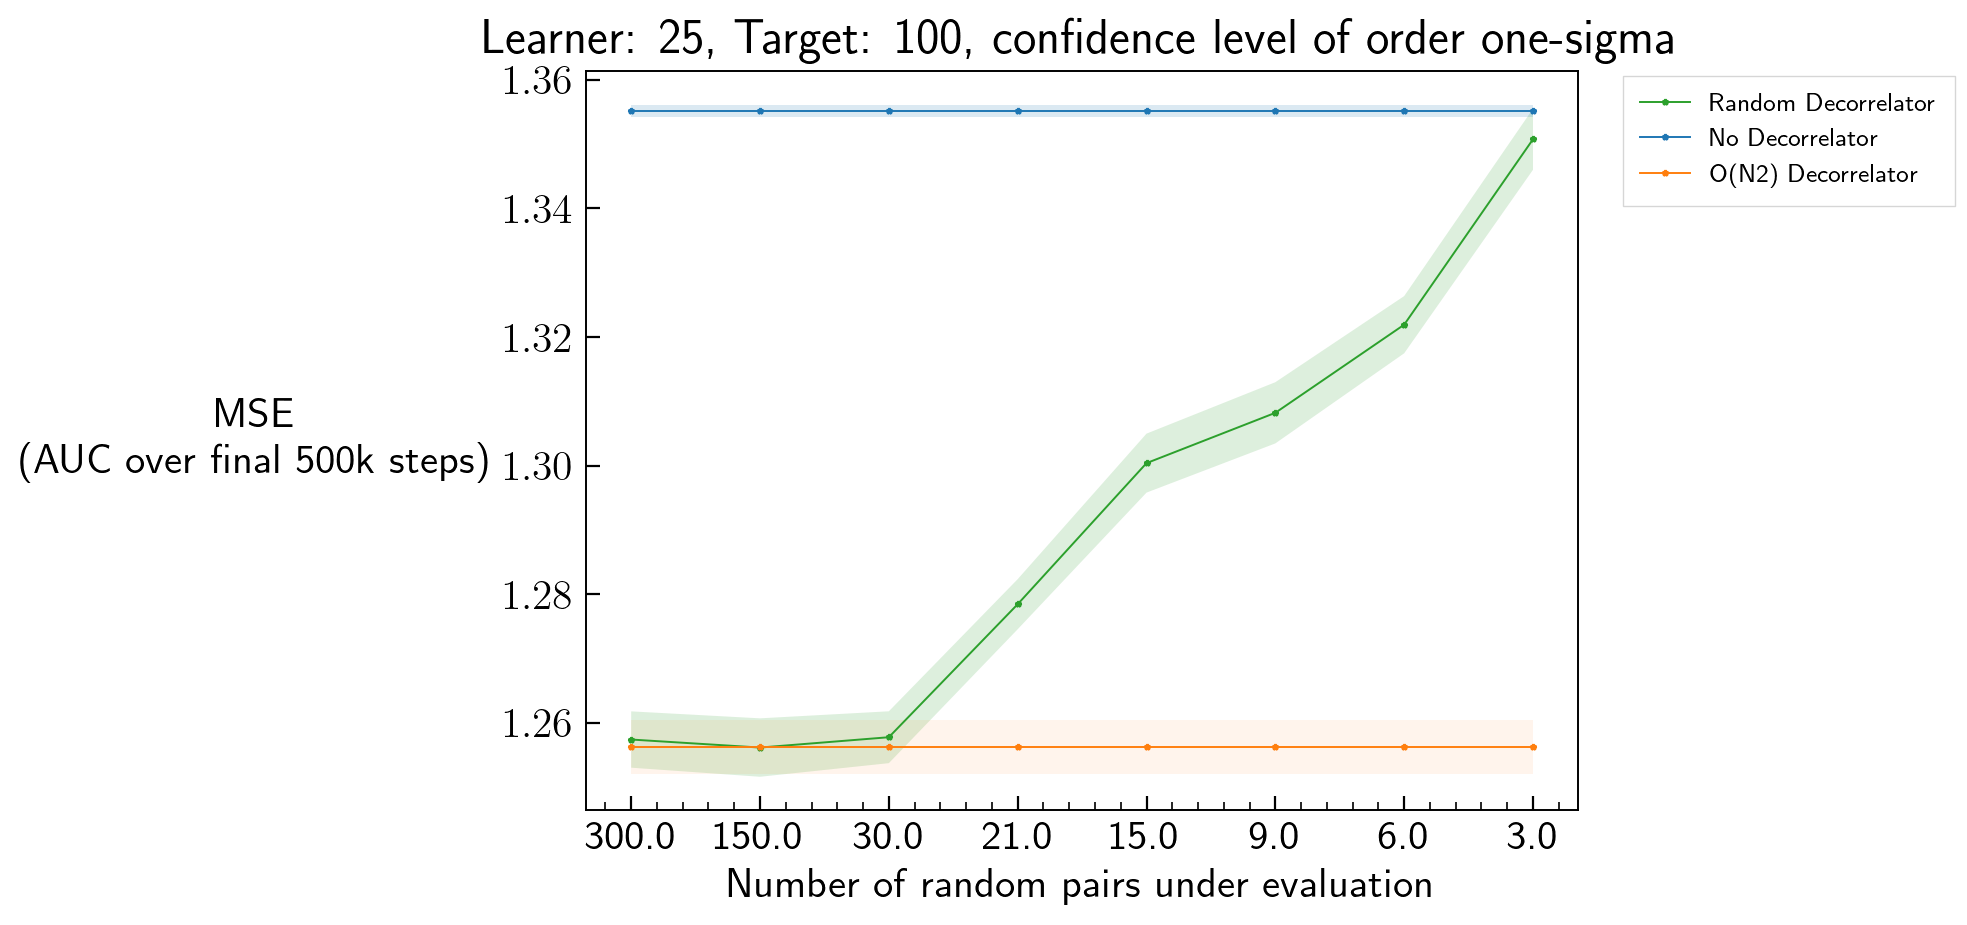

In [17]:

plt_name = f'Learner: 25, Target: 100, confidence level of order one-sigma'
fig, axs = plt.subplots(dpi=200)
plt.title(plt_name)
#plt.title(plt_name)
plt.xlabel('Number of random pairs under evaluation')
plt.ylabel('MSE \n(AUC over final 500k steps)', rotation="horizontal", ha="right", ma="center", va="center")
axs.xaxis.set_tick_params(which='major', bottom=True)
axs.xaxis.set_tick_params(which='minor', bottom=True)
axs.minorticks_on()

colors = plt.cycler(color=sns.color_palette("Set1", n_colors=10)).by_key()['color']
#colors = plt.cycler(color=sns.color_palette("tab10", n_colors=4)).by_key()['color']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

color_idx = 2

values = pd.read_sql(f'select count(*), perc_of_total_pairs_to_estimate, avg(error), std(error)/sqrt(count(*)) from error_table join runs where runs.run = error_table.run and step>=4500001 and perc_of_total_pairs_to_estimate != 0.004 group by perc_of_total_pairs_to_estimate', db1.conn)#.values[:,-1]
total_runs = values.values[:,0]
x_axis = (25*24*0.5*values.values[:,1].astype(float)).astype('str')
#x_axis[3] = '7.0'
x_axis[3] = '21.0'
acc_mean = values.values[:,2]
err = values.values[:,3]
plt.plot(x_axis, acc_mean, label=f"Random Decorrelator", color=colors[color_idx], linestyle='-', linewidth=0.7, marker='*', markersize=2)
plt.fill_between(x_axis, acc_mean-err, acc_mean+err, alpha=0.16, color=colors[color_idx], edgecolor=None)

color_idx = 0 

values = pd.read_sql(f'select count(*), avg(error), std(error)/sqrt(count(*)) from error_table join runs where runs.run = error_table.run and step>=4500001 and n_learner_features=25', db2.conn)#.values[:,-1]
total_runs = values.values[:,0]
acc_mean = np.repeat(values.values[:,1], x_axis.size)
err = np.repeat(values.values[:,2], x_axis.size)
plt.plot(x_axis, acc_mean, label=f"No Decorrelator", color=colors[color_idx], linestyle='-', linewidth=0.7, marker='*', markersize=2)
plt.fill_between(x_axis, acc_mean-err, acc_mean+err, alpha=0.16, color=colors[color_idx], edgecolor=None)

color_idx =1

values = pd.read_sql(f'select count(*), avg(error), std(error)/sqrt(count(*)) from error_table join runs where runs.run = error_table.run and step>=4500001 and n_learner_features=25 and n2_decorrelate=1', db3.conn)#.values[:,-1]
total_runs = values.values[:,0]
acc_mean = np.repeat(values.values[:,1], x_axis.size)
err = np.repeat(values.values[:,2], x_axis.size)
plt.plot(x_axis, acc_mean, label=f"O(N2) Decorrelator", color=colors[color_idx], linestyle='-', linewidth=0.7, marker='*', markersize=2)
plt.fill_between(x_axis, acc_mean-err, acc_mean+err, alpha=0.08, color=colors[color_idx], edgecolor=None)


legend = plt.legend(prop={'size': 9}, bbox_to_anchor=(1.04,1), loc="upper left")
#plt.axhline(y=0.00, color='black', linestyle=':', linewidth=2, alpha=0.3)

frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.5)
frame.set_boxstyle('Square')
plt.yscale('linear')
plt.savefig('figures/plt_scale_err.svg', bbox_inches='tight', transparent=True)
plt.show()

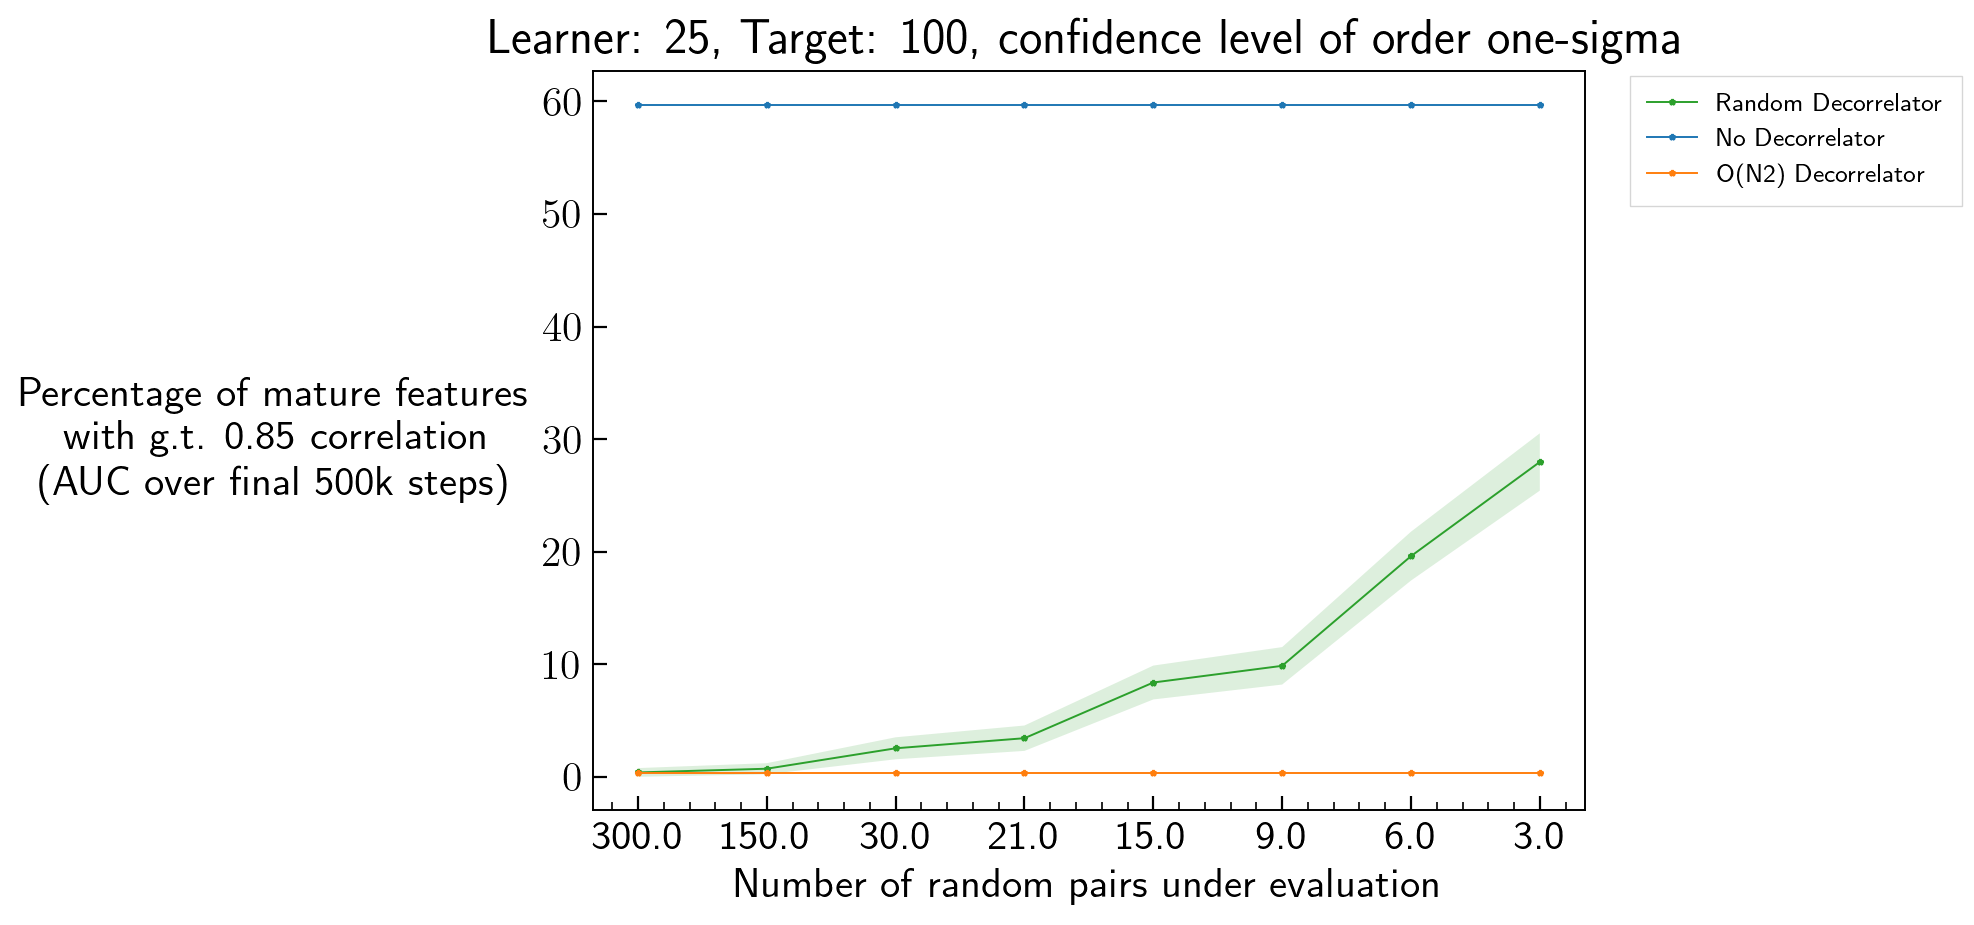

In [18]:

plt_name = f'Learner: 25, Target: 100, confidence level of order one-sigma'
fig, axs = plt.subplots(dpi=200)
plt.title(plt_name)
#plt.title(plt_name)
plt.xlabel('Number of random pairs under evaluation')
plt.ylabel('Percentage of mature features \nwith g.t. 0.85 correlation  \n (AUC over final 500k steps)', rotation='horizontal', ha='right', ma='center', va='center')
axs.xaxis.set_tick_params(which='major', bottom=True)
axs.xaxis.set_tick_params(which='minor', bottom=True)
axs.minorticks_on()

colors = plt.cycler(color=sns.color_palette("Set1", n_colors=10)).by_key()['color']
#colors = plt.cycler(color=sns.color_palette("tab10", n_colors=4)).by_key()['color']
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"]

color_idx = 2

values = pd.read_sql(f'select count(*), perc_of_total_pairs_to_estimate, avg((n_correlated/n_mature)*100), std((n_correlated/n_mature)*100)/sqrt(count(*)) from error_table join runs where runs.run = error_table.run and step=4500001 and perc_of_total_pairs_to_estimate != 0.004 group by perc_of_total_pairs_to_estimate', db1.conn)#.values[:,-1]
total_runs = values.values[:,0]
x_axis = (25*24*0.5*values.values[:,1].astype(float)).astype('str')
#x_axis[3] = '7.0'
x_axis[3] = '21.0'
acc_mean = values.values[:,2]
err = values.values[:,3]
plt.plot(x_axis, acc_mean, label=f"Random Decorrelator", color=colors[color_idx], linestyle='-', linewidth=0.7, marker='*', markersize=2)
plt.fill_between(x_axis, acc_mean-err, acc_mean+err, alpha=0.16, color=colors[color_idx], edgecolor=None)

color_idx =0

values = pd.read_sql(f'select count(*), avg((n_correlated/n_mature)*100), std((n_correlated/n_mature)*100)/sqrt(count(*)) from error_table join runs where runs.run = error_table.run and step>=4500001 and n_learner_features=25', db2.conn)#.values[:,-1]
total_runs = values.values[:,0]
acc_mean = np.repeat(values.values[:,1], x_axis.size)
err = np.repeat(values.values[:,2], x_axis.size)
plt.plot(x_axis, acc_mean, label=f"No Decorrelator", color=colors[color_idx], linestyle='-', linewidth=0.7, marker='*', markersize=2)
plt.fill_between(x_axis, acc_mean-err, acc_mean+err, alpha=0.16, color=colors[color_idx], edgecolor=None)

color_idx =1

values = pd.read_sql(f'select count(*), avg((n_correlated/n_mature)*100), std((n_correlated/n_mature)*100)/sqrt(count(*)) from error_table join runs where runs.run = error_table.run and step>=4500001 and n_learner_features=25 and n2_decorrelate=1', db3.conn)#.values[:,-1]
total_runs = values.values[:,0]
acc_mean = np.repeat(values.values[:,1], x_axis.size)
err = np.repeat(values.values[:,2], x_axis.size)
plt.plot(x_axis, acc_mean, label=f"O(N2) Decorrelator", color=colors[color_idx], linestyle='-', linewidth=0.7, marker='*', markersize=2)
plt.fill_between(x_axis, acc_mean-err, acc_mean+err, alpha=0.08, color=colors[color_idx], edgecolor=None)


legend = plt.legend(prop={'size': 9}, bbox_to_anchor=(1.04,1), loc="upper left")
#plt.axhline(y=0.00, color='black', linestyle=':', linewidth=2, alpha=0.3)

frame = legend.get_frame()
#frame.set_edgecolor('black')
frame.set_linewidth(0.5)
frame.set_boxstyle('Square')
plt.yscale('linear')
plt.savefig('figures/plt_scale_corr.svg', bbox_inches='tight', transparent=True)
plt.show()